In [17]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [18]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [19]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [20]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [21]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with = engine)

In [22]:
# View all of the classes that automap found
Base.classes.keys()

['station', 'measurement']

In [23]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [24]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [25]:
# Find the most recent date in the data set.
most_recent_date = session.query(measurement.date).\
    order_by(measurement.date.desc()).first()[0]

most_recent_date

'2017-08-23'

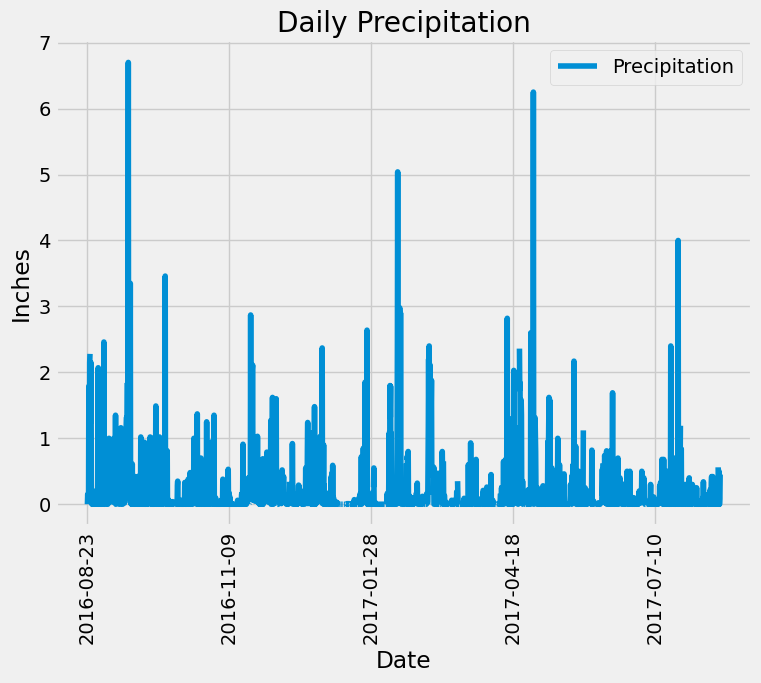

In [26]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
year_ago = dt.datetime.strptime(most_recent_date, '%Y-%m-%d') \
    - dt.timedelta(days = 366)

# Perform a query to retrieve the data and precipitation scores
precip_query = session\
    .query(measurement.date, measurement.prcp)\
    .filter(measurement.date >= year_ago)\
    .filter(measurement.date <= most_recent_date)\
    .order_by(measurement.date)\
    .all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precip_df = pd.DataFrame(precip_query, columns = ["Date", "Precipitation"])

# Use Pandas Plotting with Matplotlib to plot the data
precip_df.plot(figsize = (8, 6),
                x = 'Date',
                ylabel = 'Inches',
                title = 'Daily Precipitation',
                rot = 90
                )
plt.savefig("Images/precipitation.png", bbox_inches = 'tight')
plt.show()

In [27]:
# Use Pandas to calculate the summary statistics for the precipitation data
precip_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [28]:
# Design a query to calculate the total number of stations in the dataset
station_count = session.query(station).count()

station_count

9

In [29]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(measurement.station, func.count(measurement.station))\
    .group_by(measurement.station)\
    .order_by(func.count(measurement.station).desc())\
    .all()

active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [30]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = active_stations[0][0]

session.query(func.min(measurement.tobs), func.max(measurement.tobs), func.avg(measurement.tobs))\
    .filter(measurement.station == most_active_station)\
    .all()

[(54.0, 85.0, 71.66378066378067)]

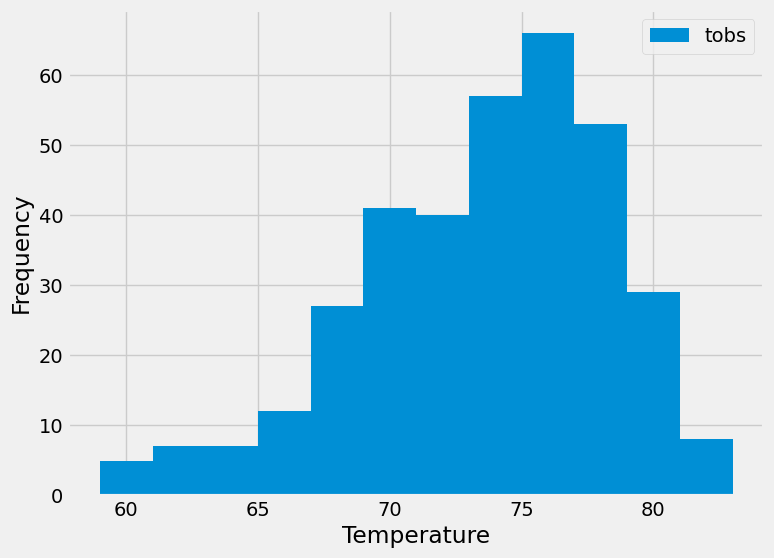

In [31]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_obs = session\
    .query(measurement.date, measurement.tobs)\
    .filter(measurement.date >= year_ago)\
    .filter(measurement.date <= most_recent_date)\
    .filter(measurement.station == most_active_station)\
    .order_by(measurement.tobs)\
    .all()

temp_df = pd.DataFrame(temp_obs, columns = ["date", "tobs"])

temp_df.plot(figsize = (8,6),
    kind = 'hist',
    bins = 12,
    xlabel = 'Temperature'
)
plt.savefig("Images/temp_freq.png", bbox_inches = "tight")
plt.show()

# Close Session

In [32]:
# Close Session
session.close()